In [8]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray as xr
import datetime as dt
from datetime import timedelta
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers


from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer 

2022-12-24 00:45:58.573980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
## Define paths to training and test data
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

ssrd_cutoff = 10

# Training set
train_files = ["mantua_pt","staten_pt","west_pt"]
x_train_xr, x_length  = prepare_predictor(train_files,train_path,time_reindex=False)
y_train_xr, y_length  = prepare_predictand(train_files,train_path,time_reindex=False)

# Test set
x_test_xr, _ = prepare_predictor('water_pt', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water_pt',data_path=test_path,time_reindex=False)

#dataframes
x_train_df = x_train_xr.to_dataframe().drop(["expver"],axis=1).dropna().reset_index()
x_train_df.ssrd = x_train_df.ssrd / 3600
x_train_df = x_train_df[x_train_df.ssrd>ssrd_cutoff]  # remove ssrd < 10

x_test_df = x_test_xr.to_dataframe().drop(["expver"],axis=1).fillna(0).reset_index()
x_test_df.ssrd = x_test_df.ssrd / 3600
x_test_df = x_test_df[x_test_df.ssrd>ssrd_cutoff]  # remove ssrd < 10

y_train_df = y_train_xr.to_dataframe().dropna()
y_train_df = y_train_df.reset_index().reset_index().merge(x_train_df.reset_index().reset_index()[["index","ssrd"]], on='index', how='right') # remove corresponding ssrd < 10
y_train_df.poa = y_train_df.poa / np.cos(0.174533) #convert to GHI
y_train_df["res"] = y_train_df.poa - y_train_df.ssrd.values
y_train_df = y_train_df.set_index(["time","lat","lon"]).drop(["index","ssrd"],axis=1)

y_test_df = y_test_xr.to_dataframe().dropna()
y_test_df = y_test_df.reset_index().reset_index().merge(x_test_df.reset_index().reset_index()[["index","ssrd"]], on='index', how='right') # remove corresponding ssrd < 10
y_test_df.poa = y_test_df.poa / np.cos(0.174533) #convert to GHI
y_test_df["res"] = y_test_df.poa - y_test_df.ssrd.values
y_test_df = y_test_df.set_index(["time","lat","lon"]).drop(["index","ssrd"],axis=1)

x_train_df = x_train_df.set_index(["time"])
x_test_df = x_test_df.set_index(["time"])

In [10]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()

x_train_df_std   = (x_train_df - x_mean)/x_std
x_test_df_std    = (x_test_df - x_mean)/x_std

y_mean, y_std = y_train_df.mean(), y_train_df.std()

y_train_df_std   = (y_train_df - y_mean)/y_std
y_test_df_std    = (y_test_df - y_mean)/y_std


x_train = x_train_df_std.to_numpy()
y_train = y_train_df_std.drop("poa",axis=1).to_numpy()
x_test = x_test_df_std.to_numpy()
y_test = y_test_df_std.drop("poa",axis=1).to_numpy()

print("Before shifting values:")
print(x_train.shape,y_train.shape)
print(x_test.shape, y_test.shape)

Before shifting values:
(15152, 5) (15152, 1)
(5728, 5) (5728, 1)


In [11]:
def QuantileLoss(perc, delta=1e-4):
    perc = np.array(perc).reshape(-1)
    perc.sort()
    perc = perc.reshape(1, -1)
    def _qloss(y, pred):
        I = tf.cast(y <= pred, tf.float32)
        d = K.abs(y - pred)
        correction = I * (1 - perc) + (1 - I) * perc
        # huber loss
        huber_loss = K.sum(correction * tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta), -1)
        # order loss
        q_order_loss = K.sum(K.maximum(0.0, pred[:, :-1] - pred[:, 1:] + 1e-6), -1)
        return huber_loss + q_order_loss
    return _qloss

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


2022-12-24 00:46:02.095428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Inital test eval on different site:
179/179 [==============================] - 1s 562us/step - loss: 2.2392
Epoch 1/50
119/119 [==============================] - 1s 2ms/step - loss: 1.6998 - val_loss: 1.8982
Epoch 2/50
119/119 [==============================] - 0s 2ms/step - loss: 1.6737 - val_loss: 1.8917
Epoch 3/50
119/119 [==============================] - 0s 2ms/step - loss: 1.6569 - val_loss: 1.8889
Epoch 4/50
119/119 [==============================] - 0s 2ms/step - loss: 1.6474 - val_loss: 1.8875
Epoch 5/50
119/119 [==============================] - 0s 1ms/step - loss: 1.6417 - val_loss: 1.8872
Epoch 6/50
119/119 [==============================] - 0s 1ms/step - loss: 1.6381 - val_loss: 1.8877
Epoch 7/50
119/119 [==============================] - 0s 1ms/step - loss: 1.6357 - val_loss: 1.8876
Epoch 8/50
119/119 [==============================] - 0s 1ms/step - loss: 1.6340 - val_loss: 1.8868
Epoch 9/50
119/119 [==============================] - 0s 1ms/step - loss: 1.6324 - val_loss

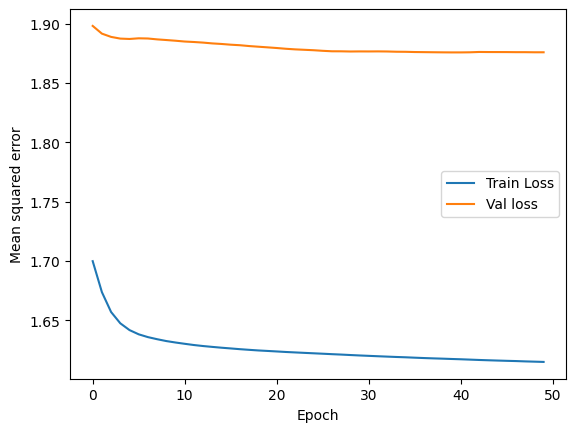

In [12]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

perc_points = [.01,.25,.5,.75,.99]

# Build and compile the model
model = Sequential()
model.add(Dense(n_neuron, activation=activation, input_shape=(x_train.shape[1],)))
model.add(Dense(n_neuron, activation=activation))
model.add(Dense(y_train.shape[-1],activation='linear'))
model.compile(loss=QuantileLoss(perc_points),optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))

model.summary()


## Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

print('\nInital test eval on different site:')
model.evaluate(x_test, y_test)

history = model.fit(x_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.5,
                        callbacks=[early_stop],
                        shuffle=False)

print('\nFinal test eval on different site:')
model.evaluate(x_test, y_test)
plot_history(history)

In [13]:
# save the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'ann_ql_model.h5'))

#visualizer(model, format='png', view=True)


In [16]:
# reload the saved model
model = load_model(os.path.join(model_path,'ssrd_res_mse_model.h5'),custom_objects={"_qloss":QuantileLoss})

# predict on the test set
y_test_pre = model.predict(x_test)

# Show results with correlation matrix
df_test = x_test_df.reset_index().drop(["lat","lon"],axis=1).set_index("time")
df_test["onsite"] = y_test_df.reset_index().drop(["lat","lon"],axis=1).set_index("time").poa
df_test["res"] = (y_test_pre* y_std.values[1] + y_mean.values[1])
df_test["pred"] = df_test["res"] + df_test.ssrd

import math 
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test['onsite'], df_test['pred'])
print("RMS: " +str(math.sqrt(mse)))

df_test.corr()



179/179 [==============================] - 0s 449us/step
RMS: 151.62303346399517


,ssrd,tcc,t2m,onsite,res,pred
ssrd,1.000000,-0.238299,0.010473,0.876271,0.432074,0.999203
tcc,-0.238299,1.000000,0.080817,-0.283976,-0.124829,-0.239077
t2m,0.010473,0.080817,1.000000,0.002815,0.037278,0.011915
onsite,0.876271,-0.283976,0.002815,1.000000,0.426608,0.877697
res,0.432074,-0.124829,0.037278,0.426608,1.000000,0.467735
pred,0.999203,-0.239077,0.011915,0.877697,0.467735,1.000000


Text(0.5, 1.0, 'Prediction versus ERA5 and Onsite Pryanometer \n April 2021 - July 2022')

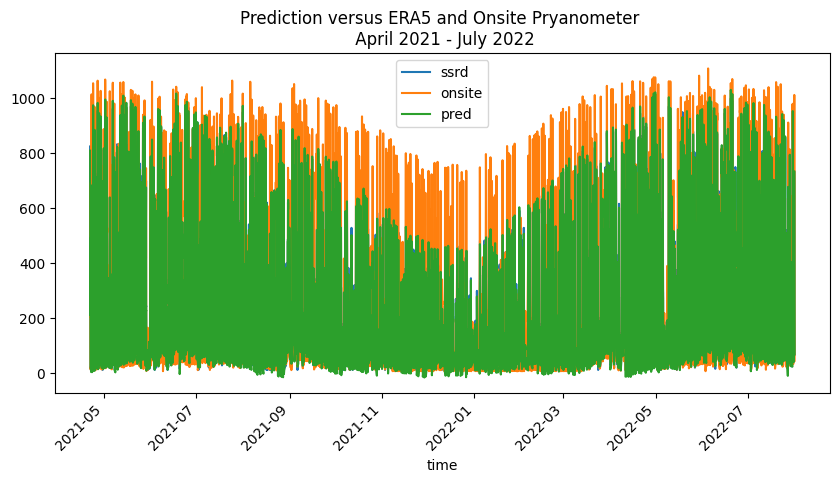

In [15]:
# Show results on total dataset
df_test = x_test_df.reset_index().drop(["lat","lon","tcc"],axis=1).set_index("time")
df_test["onsite"] = y_test_df.reset_index().drop(["lat","lon"],axis=1).set_index("time").poa
df_test["res"] = (y_test_pre* y_std.values[1] + y_mean.values[1])
df_test["pred"] = df_test["res"] + df_test.ssrd

df_plot = df_test[["ssrd","onsite","pred"]]
df_plot.plot(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Prediction versus ERA5 and Onsite Pryanometer \n April 2021 - July 2022")


Text(0.5, 1.0, 'Predicted vs Actual')

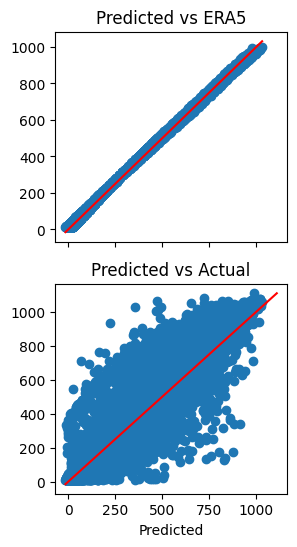

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(3,6))

# Compare against input ssrd values
ax1.scatter(df_test.pred,df_test.ssrd)
p1 = max(max(df_test.pred), max(df_test.ssrd))
p2 = min(min(df_test.pred), min(df_test.ssrd))
ax1.plot([p1, p2], [p1, p2], 'r-')
ax1.set_title("Predicted vs ERA5")

# Compare against y actual
ax2.scatter(df_test.pred,df_test.onsite)
p1 = max(max(df_test.pred), max(df_test.onsite))
p2 = min(min(df_test.pred), min(df_test.onsite))
ax2.plot([p1, p2], [p1, p2], 'r-')
ax2.set_xlabel("Predicted")
ax2.set_title("Predicted vs Actual")

(array([0, 1, 2, 3]),
 [Text(0, 0, '03-27-22'),
  Text(1, 0, '03-28-22'),
  Text(2, 0, '03-29-22'),
  Text(3, 0, '03-30-22')])

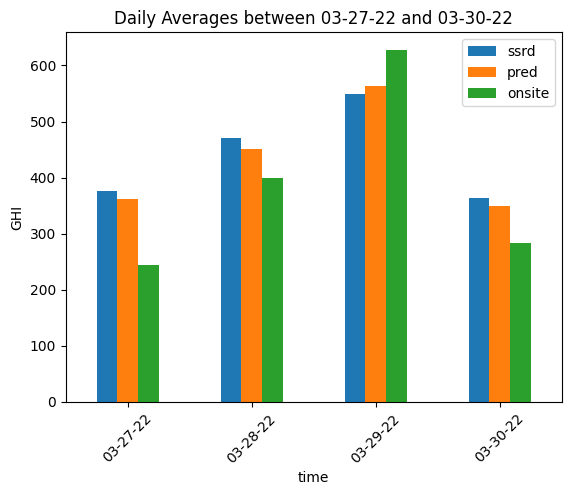

In [327]:
ind = np.arange(10)
width = 0.3       

df_bar = df_test[(df_test.index > dt.datetime(year=2022,month=3,day=27))&(df_test.index < dt.datetime(year=2022,month=3,day=31))].resample("D").mean()
df_bar.index = df_bar.index.strftime("%m-%d-%y")
df_bar[["ssrd","pred","onsite"]].plot(kind='bar')
plt.ylabel("GHI")
plt.title("Daily Averages between " + df_bar.index[0] + " and " + df_bar.index[-1])
plt.xticks(rotation=45)

(array([18797., 18799., 18801., 18803., 18805., 18807., 18809., 18811.]),
 [Text(18797.0, 0, '2021-06-19'),
  Text(18799.0, 0, '2021-06-21'),
  Text(18801.0, 0, '2021-06-23'),
  Text(18803.0, 0, '2021-06-25'),
  Text(18805.0, 0, '2021-06-27'),
  Text(18807.0, 0, '2021-06-29'),
  Text(18809.0, 0, '2021-07-01'),
  Text(18811.0, 0, '2021-07-03')])

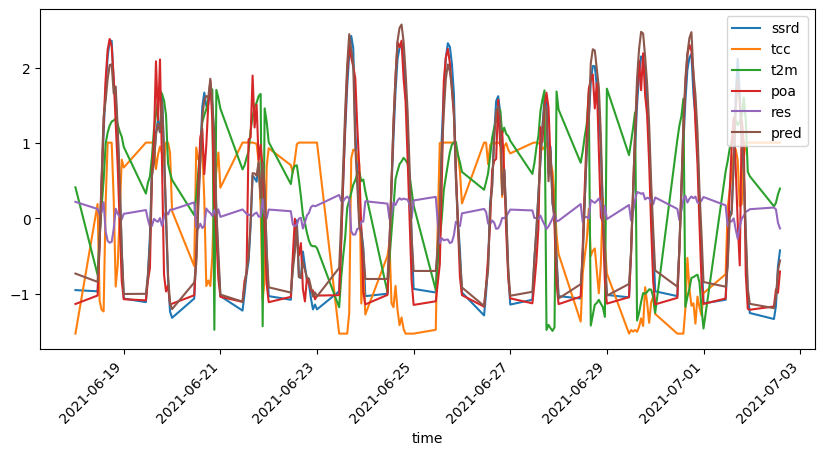

In [294]:
### STD
#plot the results
df_test = x_test_df_std.reset_index().drop(["lat","lon"],axis=1).set_index("time")
df_test["poa"] = y_test_df_std.reset_index().drop(["lat","lon"],axis=1).set_index("time").poa
df_test["res"] = y_test_pre
df_test["pred"] = df_test.res + df_test.ssrd

df_plot = df_test[800:1000]
df_plot.plot(figsize=(10,5))
plt.xticks(rotation=45)

(array([18776., 18779., 18783., 18787., 18791., 18795., 18799., 18803.,
        18807., 18809.]),
 [Text(18776.0, 0, '2021-05-29'),
  Text(18779.0, 0, '2021-06-01'),
  Text(18783.0, 0, '2021-06-05'),
  Text(18787.0, 0, '2021-06-09'),
  Text(18791.0, 0, '2021-06-13'),
  Text(18795.0, 0, '2021-06-17'),
  Text(18799.0, 0, '2021-06-21'),
  Text(18803.0, 0, '2021-06-25'),
  Text(18807.0, 0, '2021-06-29'),
  Text(18809.0, 0, '2021-07-01')])

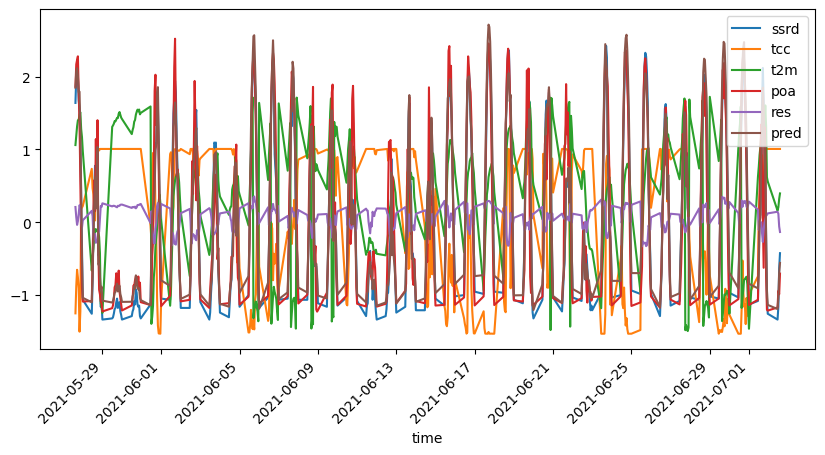

In [295]:
df_plot = df_test[500:1000]
df_plot.plot(figsize=(10,5))
plt.xticks(rotation=45)

In [297]:
df_test

,ssrd,tcc,t2m,poa,res,pred
time,,,,,,
2021-04-21 17:00:00,1.782129,0.713309,-0.254204,1.201847,-0.145226,1.636904
2021-04-21 18:00:00,1.462311,0.989513,-0.651113,0.301610,-0.258351,1.203960
2021-04-21 19:00:00,-0.504573,1.002054,-0.977050,-0.004896,-0.065562,-0.570135
2021-04-21 20:00:00,-0.136782,-0.697283,-1.371494,-0.523547,0.180246,0.043464
2021-04-21 21:00:00,0.502855,-1.079154,1.646109,0.105997,0.100419,0.603274
...,...,...,...,...,...,...
2022-07-31 19:00:00,0.119073,1.006389,1.551012,0.538552,0.119467,0.238539
2022-07-31 20:00:00,0.103082,1.006389,1.518807,0.109441,0.114028,0.217109
2022-07-31 21:00:00,-0.104800,1.006389,1.410735,-0.430562,0.103936,-0.000864


In [ ]:
plt.bar(ind, blue_bar , width, label='Blue bar label')
plt.bar(ind + width, orange_bar, width, label='Orange bar label')


<AxesSubplot: xlabel='time'>

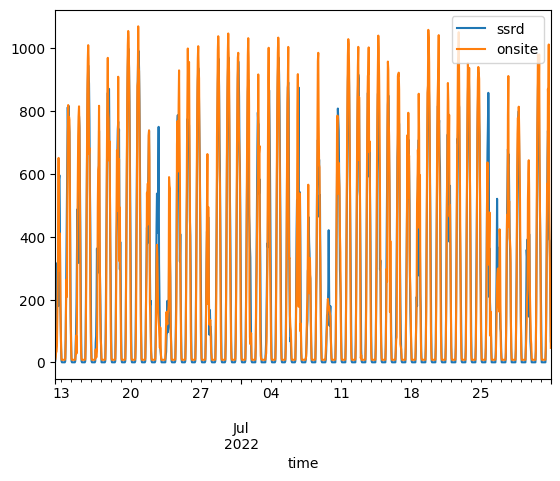

In [65]:
df_test[["ssrd","onsite"]][10000:12000].plot()